<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_gnn_bimamba_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V9: Bidirectional GNN-Mamba for Monthly Precipitation Prediction

## Advanced State Space Models with Geographic Encoding and Frequency Tuning

**Key Innovations from Literature Review:**
- **BidirectionalMamba** (RiverMamba, NeurIPS 2025): Bidirectional SSM processing
- **FrequencyTuning** (S4D-FT, WRR 2025): Learnable frequency domain filtering
- **GeographicEncoding** (WSSM, arXiv 2025): Spatial position embeddings

### Architecture Overview

| Component | V8 (Baseline) | V9 (This Model) |
|-----------|---------------|------------------|
| Spatial Encoder | GNN (GAT) | GNN (GAT) + **GeographicEncoding** |
| Temporal Encoder | Bidirectional Mamba | **BidirectionalMamba** (improved) |
| Signal Processing | None | **FrequencyTuning** |
| Fusion | Cross-Attention | Cross-Attention |

### Expected Improvements
- Better capture of seasonal cycles via frequency tuning
- Improved spatial awareness via geographic encoding
- Enhanced bidirectional temporal modeling

### Target Metrics
| Metric | V8 Baseline | V9 Target |
|--------|-------------|----------|
| R2 | 0.60 | > 0.62 |
| RMSE | 82 mm | < 78 mm |

## 1. Environment Setup

In [1]:
# ============================================================
# SECTION 1: ENVIRONMENT SETUP
# ============================================================

import os
import sys
import json
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules
SEED = 42

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')

    # Install dependencies
    import torch
    TORCH_VERSION = torch.__version__.split('+')[0]
    CUDA_VERSION = torch.version.cuda
    if CUDA_VERSION:
        CUDA_TAG = f"cu{CUDA_VERSION.replace('.', '')}"
    else:
        CUDA_TAG = 'cpu'

    print(f"PyTorch: {TORCH_VERSION}")
    print(f"CUDA: {CUDA_VERSION}")

    # Install torch_geometric
    try:
        import torch_geometric
        print(f"PyG already installed: {torch_geometric.__version__}")
    except ImportError:
        print("Installing PyTorch Geometric...")
        pyg_url = f"https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_TAG}.html"
        !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f $pyg_url
        !pip install torch-geometric

    # Install Mamba
    print("\nInstalling Mamba SSM...")
    !pip install mamba-ssm causal-conv1d>=1.1.0 --quiet

    # Other dependencies
    !pip install netCDF4 xarray dask h5netcdf --quiet

    print("\nEnvironment versions:")
    print(sys.version)
    print(torch.__version__)
    print(torch.version.cuda)

    env_info = {
        'python': sys.version,
        'torch': torch.__version__,
        'cuda': torch.version.cuda
    }
    try:
        import torch_geometric
        env_info['torch_geometric'] = torch_geometric.__version__
        print(f"PyG: {torch_geometric.__version__}")
    except Exception:
        print("PyG: not available")
    try:
        import mamba_ssm
        env_info['mamba_ssm'] = mamba_ssm.__version__
        print(f"Mamba-SSM: {mamba_ssm.__version__}")
    except Exception:
        print("Mamba-SSM: not available")

    env_dir = BASE_PATH / 'models' / 'output' / 'env_versions'
    env_dir.mkdir(parents=True, exist_ok=True)
    env_path = env_dir / 'v9_env_versions.json'
    with open(env_path, 'w') as f:
        json.dump(env_info, f, indent=2)
    print(f"Saved environment versions to: {env_path}")

else:
    # Local environment
    BASE_PATH = Path(r'd:\github.com\ninja-marduk\ml_precipitation_prediction')
    print(f"Running locally, BASE_PATH: {BASE_PATH}")

print(f"\nBase path: {BASE_PATH}")
print(f"Base path exists: {BASE_PATH.exists()}")


Mounted at /content/drive
PyTorch: 2.9.0
CUDA: 12.6
Installing PyTorch Geometric...
Looking in links: https://data.pyg.org/whl/torch-2.9.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3869125 sha256=d14b392061993a6a81b21fbf63f9e1b7ed8f15a2e1e145bafc6912a79f6dd063
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=3038298 sha256=ef5416e045207302f71fe95fbf4801de4583892c91ad526

In [2]:
# ============================================================
# SECTION 1.1: IMPORTS
# ============================================================

import json
import sys
import gc
import copy
import warnings
import math
from datetime import datetime
from dataclasses import dataclass, field, asdict
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Literal

import numpy as np
import pandas as pd
import xarray as xr

# Matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data, Batch

# Scikit-learn
from sklearn.cluster import KMeans
from scipy import stats

# Mamba SSM
PREFER_OFFICIAL_MAMBA = True
REQUIRE_OFFICIAL_MAMBA = False
USE_OFFICIAL_MAMBA = False
MAMBA_BACKEND = "custom"
try:
    from mamba_ssm import Mamba
    if PREFER_OFFICIAL_MAMBA:
        USE_OFFICIAL_MAMBA = True
        MAMBA_BACKEND = "official"
        print("Using official mamba-ssm package for Mamba blocks")
    else:
        print("Official mamba-ssm available but disabled; using custom implementation")
except ImportError as e:
    if REQUIRE_OFFICIAL_MAMBA:
        raise RuntimeError(
            "mamba-ssm not available but REQUIRE_OFFICIAL_MAMBA=True. "
            "Install mamba-ssm or set REQUIRE_OFFICIAL_MAMBA=False."
        ) from e
    print("Official mamba-ssm not available, using custom implementation (slower; may trigger CUDA timeout on Windows)")

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings('ignore')


Official mamba-ssm not available, using custom implementation (slower; may trigger CUDA timeout on Windows)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB


## 2. Configuration

In [3]:
# ============================================================
# SECTION 2: V9 CONFIGURATION
# ============================================================

@dataclass
class V9Config:
    """V9 Bidirectional GNN-Mamba Configuration.

    Key additions from literature review:
    - BidirectionalMamba (RiverMamba NeurIPS 2025)
    - FrequencyTuning (S4D-FT WRR 2025)
    - GeographicEncoding (WSSM arXiv 2025)
    """

    # === Model Dimensions ===
    hidden_dim: int = 64
    d_state: int = 16
    n_gnn_layers: int = 2
    n_mamba_layers: int = 2
    n_attention_heads: int = 4
    dropout: float = 0.1
    n_features: int = 5

    # === Bidirectional Mamba (RiverMamba) ===
    bidirectional: bool = True
    combine_method: str = 'concat_linear'  # 'concat_linear', 'add', 'gate'
    mamba_d_conv: int = 4
    mamba_expand: int = 2

    # === Frequency Tuning (S4D-FT) ===
    use_frequency_tuning: bool = True
    n_freq_bands: int = 4

    # === Geographic Encoding (WSSM) ===
    use_geographic_encoding: bool = True
    n_lat: int = 61
    n_lon: int = 65
    n_nodes: int = 61 * 65

    # === GNN Configuration ===
    gnn_type: str = 'GAT'
    gnn_num_heads: int = 4
    gnn_dropout: float = 0.1

    # === Cross-Modal Attention ===
    cross_attn_heads: int = 4
    cross_attn_dropout: float = 0.1

    # === Training ===
    epochs: int = 150
    batch_size: int = 4
    learning_rate: float = 0.0003
    patience: int = 60
    weight_decay: float = 1e-4
    gradient_clip: float = 1.0

    # === Physics Loss ===
    use_physics_loss: bool = True
    lambda_mass_conservation: float = 0.05
    lambda_orographic: float = 0.1
    high_elev_threshold: float = 3000.0

    # === Data ===
    input_window: int = 60
    horizon: int = 12
    train_val_split: float = 0.8
    light_mode: bool = False
    light_grid_size: int = 10
    enabled_horizons: List[int] = field(default_factory=lambda: [12])

    # === Scheduler ===
    scheduler_type: str = 'cosine'
    cosine_T0: int = 20
    cosine_T_mult: int = 2

    # === Chunking for memory ===
    mamba_node_chunk: int = 256

    # === Output ===
    output_dir: str = 'V9_GNN_BiMamba'
    save_checkpoints: bool = True

    # === Data handling ===
    allow_missing_features: bool = True

    # === Outputs / Diagnostics ===
    export_predictions: bool = True
    export_history: bool = True
    plot_graph_diagnostics: bool = True
    plot_results_summary: bool = True
    plot_metrics_table: bool = True
    generate_map_plots: bool = True
    map_export_horizon: int = 1
    map_export_max_samples: int = 3

    # === Quality checks ===
    enforce_quality_gates: bool = False
    quality_neg_pred_max: float = 0.01
    quality_nan_max: float = 0.0
    quality_bias_pct_max: float = 25.0

    # === Expected performance ===
    target_r2: float = 0.62
    target_rmse: float = 78.0


# Feature sets
FEATURE_SETS = {
    'BASIC': ['total_precipitation'],
    'KCE': ['total_precipitation', 'elev_low', 'elev_med', 'elev_high'],
    'FULL': ['total_precipitation', 'elevation', 'slope', 'aspect',
             'elev_low', 'elev_med', 'elev_high']
}

# Initialize config
CONFIG = V9Config()

# Adjust for Colab memory constraints
if IN_COLAB:
    CONFIG.batch_size = 2
    CONFIG.hidden_dim = 48
    CONFIG.d_state = 12
    CONFIG.gnn_num_heads = 2
    print("Adjusted config for Colab memory constraints")

print("\n=== V9 Bidirectional GNN-Mamba Configuration ===")
print(f"  Input window: {CONFIG.input_window} months")
print(f"  Horizon: {CONFIG.horizon} months")
print(f"  Hidden dim: {CONFIG.hidden_dim}")
print(f"  d_state: {CONFIG.d_state}")
print(f"  Bidirectional: {CONFIG.bidirectional}")
print(f"  Frequency Tuning: {CONFIG.use_frequency_tuning}")
print(f"  Geographic Encoding: {CONFIG.use_geographic_encoding}")
print(f"  GNN type: {CONFIG.gnn_type}")
print(f"  Batch size: {CONFIG.batch_size}")
print(f"  Learning rate: {CONFIG.learning_rate}")
print(f"  Target R2: {CONFIG.target_r2}")
print(f"  Target RMSE: {CONFIG.target_rmse}")

Adjusted config for Colab memory constraints

=== V9 Bidirectional GNN-Mamba Configuration ===
  Input window: 60 months
  Horizon: 12 months
  Hidden dim: 48
  d_state: 12
  Bidirectional: True
  Frequency Tuning: True
  Geographic Encoding: True
  GNN type: GAT
  Batch size: 2
  Learning rate: 0.0003
  Target R2: 0.62
  Target RMSE: 78.0


## 3. New V9 Modules

### 3.1 BidirectionalMamba (RiverMamba NeurIPS 2025)
### 3.2 FrequencyTuning (S4D-FT WRR 2025)
### 3.3 GeographicEncoding (WSSM arXiv 2025)

In [4]:
# ============================================================
# SECTION 3: V9 NEW MODULES
# ============================================================

# -------------------------------------------------------------
# 3.1 Custom Mamba Block (fallback when official not available)
# -------------------------------------------------------------

class MambaBlock(nn.Module):
    """
    Selective State Space Model Block.
    Based on: "Mamba: Linear-Time Sequence Modeling with Selective State Spaces"
    """

    def __init__(
        self,
        d_model: int,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()

        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.d_inner = d_model * expand

        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            kernel_size=d_conv,
            padding=d_conv - 1,
            groups=self.d_inner
        )
        self.x_proj = nn.Linear(self.d_inner, d_state * 2 + 1, bias=False)
        A = torch.arange(1, d_state + 1, dtype=torch.float32)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, seq_len, _ = x.shape
        residual = x

        xz = self.in_proj(x)
        x_branch, z = xz.chunk(2, dim=-1)

        x_conv = x_branch.transpose(1, 2)
        x_conv = self.conv1d(x_conv)[:, :, :seq_len]
        x_conv = x_conv.transpose(1, 2)
        x_conv = F.silu(x_conv)

        y = self.ssm(x_conv)
        z = F.silu(z)
        output = y * z

        output = self.out_proj(output)
        output = self.dropout(output)
        output = self.norm(output + residual)

        return output

    def ssm(self, x: torch.Tensor) -> torch.Tensor:
        batch, seq_len, d_inner = x.shape
        device = x.device

        x_proj = self.x_proj(x)
        B = x_proj[:, :, :self.d_state]
        C = x_proj[:, :, self.d_state:2*self.d_state]
        dt = F.softplus(x_proj[:, :, -1:])

        A = -torch.exp(self.A_log.float())
        A_bar = torch.exp(A.view(1, 1, self.d_state) * dt)
        B_bar = B * dt

        h = torch.zeros(batch, d_inner, self.d_state, device=device)
        outputs = []

        for t in range(seq_len):
            h = h * A_bar[:, t, :].unsqueeze(1) + \
                x[:, t, :].unsqueeze(-1) * B_bar[:, t, :].unsqueeze(1)
            y_t = (h * C[:, t, :].unsqueeze(1)).sum(dim=-1)
            outputs.append(y_t)

        y = torch.stack(outputs, dim=1)
        y = y + x * self.D.view(1, 1, -1)

        return y


class OfficialMambaBlock(nn.Module):
    '''
    Wrapper around the official mamba-ssm Mamba module with residual + norm.

    Uses the official CUDA kernels when available.
    '''

    def __init__(
        self,
        d_model: int,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        y = self.mamba(x)
        y = self.dropout(y)
        return self.norm(y + residual)


# -------------------------------------------------------------
# 3.2 BidirectionalMamba (RiverMamba NeurIPS 2025)
# -------------------------------------------------------------

class BidirectionalMamba(nn.Module):
    """
    Bidirectional Mamba block from RiverMamba (NeurIPS 2025).

    Processes sequences in both forward and backward directions,
    then combines the representations for improved temporal modeling.
    """

    def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
        super().__init__()

        # Use official Mamba if available, otherwise custom
        block_cls = OfficialMambaBlock if USE_OFFICIAL_MAMBA else MambaBlock
        self.mamba_fwd = block_cls(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout)
        self.mamba_bwd = block_cls(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout=dropout)

        # Combination layer
        self.combine = nn.Linear(d_model * 2, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            output: (batch, seq_len, d_model)
        """
        # Forward direction
        x_fwd = self.mamba_fwd(x)

        # Backward direction (flip, process, flip back)
        x_bwd = self.mamba_bwd(torch.flip(x, dims=[1]))
        x_bwd = torch.flip(x_bwd, dims=[1])

        # Combine forward and backward
        combined = self.combine(torch.cat([x_fwd, x_bwd], dim=-1))
        combined = self.dropout(combined)

        # Residual connection and normalization
        return self.norm(combined + x)


# -------------------------------------------------------------
# 3.3 FrequencyTuning (S4D-FT WRR 2025)
# -------------------------------------------------------------

class FrequencyTuning(nn.Module):
    """
    Frequency-domain tuning module from S4D-FT (WRR 2025).

    Learns to filter signals in the frequency domain to better
    capture seasonal and periodic patterns in precipitation data.
    """

    def __init__(self, d_model: int, n_freq_bands: int = 4):
        super().__init__()

        self.d_model = d_model
        self.n_freq_bands = n_freq_bands

        # Learnable frequency filter
        self.freq_filter = nn.Conv1d(d_model, d_model, kernel_size=1)

        # Learnable mixing coefficient
        self.alpha = nn.Parameter(torch.ones(1) * 0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            output: (batch, seq_len, d_model)
        """
        B, T, D = x.shape

        # Time domain representation
        x_time = x

        # Transform to frequency domain
        x_freq = torch.fft.rfft(x, dim=1)

        # Apply learnable filter to real part
        x_freq_real = self.freq_filter(x_freq.real.transpose(1, 2)).transpose(1, 2)

        # Reconstruct complex tensor
        x_freq_filtered = torch.complex(x_freq_real, x_freq.imag)

        # Transform back to time domain
        x_freq_out = torch.fft.irfft(x_freq_filtered, n=T, dim=1)

        # Learnable mix of time and frequency representations
        alpha = torch.sigmoid(self.alpha)
        return alpha * x_time + (1 - alpha) * x_freq_out


# -------------------------------------------------------------
# 3.4 GeographicEncoding (WSSM arXiv 2025)
# -------------------------------------------------------------

class GeographicEncoding(nn.Module):
    """
    Geographic position encoding from WSSM (arXiv 2025).

    Encodes spatial position (latitude, longitude, elevation) to
    provide the model with geographic awareness.
    """

    def __init__(self, d_model: int, n_lat: int = 61, n_lon: int = 65):
        super().__init__()

        self.d_model = d_model
        self.n_lat = n_lat
        self.n_lon = n_lon

        # Latitude and longitude embeddings
        lat_dim = d_model // 3
        lon_dim = d_model // 3
        elev_dim = d_model - lat_dim - lon_dim

        self.lat_embed = nn.Embedding(n_lat, lat_dim)
        self.lon_embed = nn.Embedding(n_lon, lon_dim)
        self.elev_proj = nn.Linear(1, elev_dim)

        # Output projection to ensure dimension match
        self.output_proj = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(
        self,
        x: torch.Tensor,
        lat_idx: torch.Tensor,
        lon_idx: torch.Tensor,
        elevation: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, n_nodes, d_model) or (batch, seq_len, n_nodes, d_model)
            lat_idx: (n_nodes,) latitude indices
            lon_idx: (n_nodes,) longitude indices
            elevation: (n_nodes,) elevation values
        Returns:
            output: same shape as x
        """
        # Get geographic embeddings
        lat_emb = self.lat_embed(lat_idx)  # (n_nodes, lat_dim)
        lon_emb = self.lon_embed(lon_idx)  # (n_nodes, lon_dim)
        elev_emb = self.elev_proj(elevation.unsqueeze(-1))  # (n_nodes, elev_dim)

        # Concatenate geographic features
        geo = torch.cat([lat_emb, lon_emb, elev_emb], dim=-1)  # (n_nodes, d_model)
        geo = self.output_proj(geo)  # (n_nodes, d_model)

        # Add to input (broadcast across batch and optionally time)
        if x.dim() == 3:  # (batch, n_nodes, d_model)
            geo = geo.unsqueeze(0)  # (1, n_nodes, d_model)
        elif x.dim() == 4:  # (batch, seq_len, n_nodes, d_model)
            geo = geo.unsqueeze(0).unsqueeze(0)  # (1, 1, n_nodes, d_model)

        return self.norm(x + geo)


# Test new modules
print(f"Testing V9 modules ({MAMBA_BACKEND})...")

# Test BidirectionalMamba
test_bimamba = BidirectionalMamba(d_model=64, d_state=16).to(device)
test_input = torch.randn(2, 60, 64).to(device)
test_output = test_bimamba(test_input)
print(f"BidirectionalMamba: {test_input.shape} -> {test_output.shape}")

# Test FrequencyTuning
test_freq = FrequencyTuning(d_model=64, n_freq_bands=4).to(device)
test_output = test_freq(test_input)
print(f"FrequencyTuning: {test_input.shape} -> {test_output.shape}")

# Test GeographicEncoding
test_geo = GeographicEncoding(d_model=64, n_lat=61, n_lon=65).to(device)
test_x = torch.randn(2, 100, 64).to(device)
test_lat = torch.randint(0, 61, (100,)).to(device)
test_lon = torch.randint(0, 65, (100,)).to(device)
test_elev = torch.randn(100).to(device)
test_output = test_geo(test_x, test_lat, test_lon, test_elev)
print(f"GeographicEncoding: {test_x.shape} -> {test_output.shape}")

del test_bimamba, test_freq, test_geo, test_input, test_x, test_output
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("\nAll V9 modules tested successfully!")

Testing V9 modules (custom)...
BidirectionalMamba: torch.Size([2, 60, 64]) -> torch.Size([2, 60, 64])
FrequencyTuning: torch.Size([2, 60, 64]) -> torch.Size([2, 60, 64])
GeographicEncoding: torch.Size([2, 100, 64]) -> torch.Size([2, 100, 64])

All V9 modules tested successfully!


## 4. Spatial GNN Encoder

In [5]:
# ============================================================
# SECTION 4: SPATIAL GNN ENCODER
# ============================================================

class SpatialGNNEncoder(nn.Module):
    """
    Graph Neural Network for spatial encoding.
    Supports GAT, GraphSAGE, and GCN.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_layers: int = 3,
        gnn_type: str = 'GAT',
        num_heads: int = 4,
        dropout: float = 0.1
    ):
        super().__init__()

        self.gnn_type = gnn_type
        self.num_layers = num_layers

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.gnn_layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        for i in range(num_layers):
            if gnn_type == 'GAT':
                self.gnn_layers.append(
                    GATConv(
                        in_channels=hidden_dim,
                        out_channels=hidden_dim // num_heads,
                        heads=num_heads,
                        dropout=dropout,
                        concat=True
                    )
                )
            elif gnn_type == 'SAGE':
                self.gnn_layers.append(SAGEConv(hidden_dim, hidden_dim))
            else:
                self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))

            self.norms.append(nn.LayerNorm(hidden_dim))

        self.dropout = nn.Dropout(dropout)
        self.output_norm = nn.LayerNorm(hidden_dim)

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        h = self.input_proj(x)

        for i, (gnn, norm) in enumerate(zip(self.gnn_layers, self.norms)):
            h_res = h

            if self.gnn_type == 'GAT':
                h = gnn(h, edge_index)
            elif edge_weight is not None and self.gnn_type == 'GCN':
                h = gnn(h, edge_index, edge_weight)
            else:
                h = gnn(h, edge_index)

            h = F.gelu(h)
            h = norm(h)
            h = self.dropout(h)
            h = h + h_res

        return self.output_norm(h)


print("SpatialGNNEncoder defined successfully")

SpatialGNNEncoder defined successfully


## 5. GNN-BiMamba V9 Main Model

In [6]:
# ============================================================
# SECTION 5: GNN-BIMAMBA V9 MAIN MODEL
# ============================================================

class CrossModalAttention(nn.Module):
    """
    Cross-attention between spatial (GNN) and temporal (Mamba) representations.
    """

    def __init__(self, d_model: int, num_heads: int = 4, dropout: float = 0.1):
        super().__init__()

        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, query: torch.Tensor, key_value: torch.Tensor) -> torch.Tensor:
        attn_out, _ = self.attn(query, key_value, key_value)
        x = self.norm1(query + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x


class GNN_BiMamba_V9(nn.Module):
    """
    V9: Bidirectional GNN-Mamba with Frequency Tuning and Geographic Encoding.

    Architecture:
    1. Input projection
    2. Geographic Encoding (WSSM)
    3. Parallel branches:
       - GNN: spatial encoding per timestep
       - BidirectionalMamba + FrequencyTuning: temporal encoding per node
    4. Cross-modal attention fusion
    5. Prediction head

    Improvements over V8:
    - BidirectionalMamba from RiverMamba (NeurIPS 2025)
    - FrequencyTuning from S4D-FT (WRR 2025)
    - GeographicEncoding from WSSM (arXiv 2025)
    """

    def __init__(self, config: V9Config):
        super().__init__()

        self.config = config

        # === Input Projection ===
        self.input_proj = nn.Sequential(
            nn.Linear(config.n_features, config.hidden_dim),
            nn.LayerNorm(config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout)
        )

        # === Geographic Encoding (WSSM) ===
        if config.use_geographic_encoding:
            self.geo_encoding = GeographicEncoding(
                d_model=config.hidden_dim,
                n_lat=config.n_lat,
                n_lon=config.n_lon
            )
        else:
            self.geo_encoding = None

        # === Spatial Branch: GNN ===
        self.gnn_encoder = SpatialGNNEncoder(
            input_dim=config.hidden_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.n_gnn_layers,
            gnn_type=config.gnn_type,
            num_heads=config.gnn_num_heads,
            dropout=config.gnn_dropout
        )

        # === Temporal Branch: BidirectionalMamba + FrequencyTuning ===
        self.mamba_layers = nn.ModuleList([
            BidirectionalMamba(
                d_model=config.hidden_dim,
                d_state=config.d_state,
                d_conv=config.mamba_d_conv,
                expand=config.mamba_expand,
                dropout=config.dropout
            )
            for _ in range(config.n_mamba_layers)
        ])

        # === Frequency Tuning (S4D-FT) ===
        if config.use_frequency_tuning:
            self.freq_tuning = FrequencyTuning(
                d_model=config.hidden_dim,
                n_freq_bands=config.n_freq_bands
            )
        else:
            self.freq_tuning = None

        # === Cross-Modal Fusion ===
        self.cross_attention = CrossModalAttention(
            d_model=config.hidden_dim,
            num_heads=config.cross_attn_heads,
            dropout=config.cross_attn_dropout
        )

        # === Prediction Head ===
        self.predictor = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim // 2, config.horizon)
        )

        # Store dimensions
        self.n_lat = config.n_lat
        self.n_lon = config.n_lon
        self.n_nodes = config.n_nodes

        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() >= 2:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: Optional[torch.Tensor] = None,
        lat_idx: Optional[torch.Tensor] = None,
        lon_idx: Optional[torch.Tensor] = None,
        elevation: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        """
        Forward pass.

        Args:
            x: (batch, seq_len, n_nodes, n_features)
            edge_index: (2, num_edges)
            edge_weight: (num_edges,) optional
            lat_idx: (n_nodes,) latitude indices for geo encoding
            lon_idx: (n_nodes,) longitude indices for geo encoding
            elevation: (n_nodes,) elevation values for geo encoding

        Returns:
            pred: (batch, n_nodes, horizon)
            info: dict with intermediate representations
        """
        if x.dim() == 5:  # (B, T, lat, lon, F)
            batch_size, seq_len, n_lat, n_lon, n_features = x.shape
            n_nodes = n_lat * n_lon
            x = x.view(batch_size, seq_len, n_nodes, n_features)
        else:
            batch_size, seq_len, n_nodes, n_features = x.shape

        # 1. Input projection
        x = self.input_proj(x)  # (B, T, N, H)

        # 2. Geographic encoding (optional)
        if self.geo_encoding is not None and lat_idx is not None:
            x = self.geo_encoding(x, lat_idx, lon_idx, elevation)

        # 3. Spatial encoding (GNN per timestep)
        h_spatial = self._encode_spatial(x, edge_index, edge_weight)

        # 4. Temporal encoding (BidirectionalMamba per node)
        h_temporal = self._encode_temporal(x)

        # 5. Cross-modal fusion
        h_fused = self._fuse_representations(h_spatial, h_temporal)

        # 6. Prediction
        pred = self.predictor(h_fused)

        info = {
            'h_spatial': h_spatial[:, -1, :, :],
            'h_temporal': h_temporal[:, -1, :, :],
            'h_fused': h_fused
        }

        return pred, info

    def _encode_spatial(self, x, edge_index, edge_weight):
        """Apply GNN to each timestep."""
        batch_size, seq_len, n_nodes, hidden_dim = x.shape

        chunk_size = 10
        outputs = []

        for t_start in range(0, seq_len, chunk_size):
            t_end = min(t_start + chunk_size, seq_len)
            x_chunk = x[:, t_start:t_end, :, :]

            chunk_len = t_end - t_start
            x_flat = x_chunk.reshape(batch_size * chunk_len, n_nodes, hidden_dim)

            h_list = []
            for i in range(x_flat.shape[0]):
                h_i = self.gnn_encoder(x_flat[i], edge_index, edge_weight)
                h_list.append(h_i)

            h_chunk = torch.stack(h_list, dim=0)
            h_chunk = h_chunk.view(batch_size, chunk_len, n_nodes, hidden_dim)
            outputs.append(h_chunk)

        return torch.cat(outputs, dim=1)

    def _encode_temporal(self, x):
        """Apply BidirectionalMamba + FrequencyTuning to each node's temporal sequence."""
        batch_size, seq_len, n_nodes, hidden_dim = x.shape

        chunk_size = getattr(self.config, 'mamba_node_chunk', 0) or n_nodes
        outputs = []

        for n_start in range(0, n_nodes, chunk_size):
            n_end = min(n_start + chunk_size, n_nodes)
            x_chunk = x[:, :, n_start:n_end, :]

            # Reshape: (B, T, chunk, H) -> (B*chunk, T, H)
            x_temporal = x_chunk.permute(0, 2, 1, 3)
            x_temporal = x_temporal.reshape(batch_size * (n_end - n_start), seq_len, hidden_dim)

            # Apply BidirectionalMamba layers
            h_temporal = x_temporal
            for mamba_layer in self.mamba_layers:
                h_temporal = mamba_layer(h_temporal)

            # Apply FrequencyTuning (optional)
            if self.freq_tuning is not None:
                h_temporal = self.freq_tuning(h_temporal)

            # Reshape back: (B*chunk, T, H) -> (B, T, chunk, H)
            h_temporal = h_temporal.view(batch_size, n_end - n_start, seq_len, hidden_dim)
            h_temporal = h_temporal.permute(0, 2, 1, 3)
            outputs.append(h_temporal)

        return torch.cat(outputs, dim=2)

    def _fuse_representations(self, h_spatial, h_temporal):
        """Fuse spatial and temporal representations at final timestep."""
        h_spatial_final = h_spatial[:, -1, :, :]
        h_temporal_final = h_temporal[:, -1, :, :]
        h_fused = self.cross_attention(h_spatial_final, h_temporal_final)
        return h_fused


# Test model
print("\nTesting GNN_BiMamba_V9...")
test_config = V9Config(
    n_features=4,
    n_lat=10,
    n_lon=10,
    n_nodes=100,
    hidden_dim=32,
    d_state=8,
    input_window=12,
    horizon=6
)

test_model = GNN_BiMamba_V9(test_config).to(device)
test_x = torch.randn(2, 12, 100, 4).to(device)
test_edge_index = torch.randint(0, 100, (2, 500)).to(device)

with torch.no_grad():
    test_pred, test_info = test_model(test_x, test_edge_index)

print(f"  Input shape: {test_x.shape}")
print(f"  Output shape: {test_pred.shape}")
print(f"  Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")

del test_model, test_x, test_pred, test_info
torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("\nGNN_BiMamba_V9 test passed!")


Testing GNN_BiMamba_V9...
  Input shape: torch.Size([2, 12, 100, 4])
  Output shape: torch.Size([2, 100, 6])
  Total parameters: 55,543

GNN_BiMamba_V9 test passed!


## 6. Data Loading and Preprocessing

In [7]:
# ============================================================
# SECTION 6: DATA LOADING
# ============================================================

# Paths
DATA_PATH = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / CONFIG.output_dir
DATA_OUT_DIR = OUTPUT_ROOT / 'data'
FIG_OUT_DIR = OUTPUT_ROOT / 'figures'
COMP_DIR = OUTPUT_ROOT / 'comparisons'
TRAIN_LOG_DIR = OUTPUT_ROOT / 'training_metrics'
MAP_OUT_DIR = OUTPUT_ROOT / 'map_exports'

for d in [OUTPUT_ROOT, DATA_OUT_DIR, FIG_OUT_DIR, COMP_DIR, TRAIN_LOG_DIR, MAP_OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_ROOT}")
print(f"Data exists: {DATA_PATH.exists()}")

Data path: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Output path: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba
Data exists: True


In [8]:
# ============================================================
# SECTION 6.1: DATA FUNCTIONS
# ============================================================

def validate_dataset(ds: xr.Dataset, config: V9Config) -> Tuple[str, str]:
    """Validate dataset dimensions."""
    lat_candidates = ['latitude', 'lat', 'y']
    lon_candidates = ['longitude', 'lon', 'x']

    lat_dim = next((d for d in lat_candidates if d in ds.dims), None)
    lon_dim = next((d for d in lon_candidates if d in ds.dims), None)

    if lat_dim is None or lon_dim is None:
        raise ValueError(f"Cannot find lat/lon dims in {list(ds.dims.keys())}")

    if 'time' not in ds.dims:
        raise ValueError("Dataset must have 'time' dimension")

    config.n_lat = ds.dims[lat_dim]
    config.n_lon = ds.dims[lon_dim]
    config.n_nodes = config.n_lat * config.n_lon

    return lat_dim, lon_dim


def load_dataset(data_path: Path, config: V9Config) -> xr.Dataset:
    """Load and validate NetCDF dataset."""
    print(f"Loading dataset from: {data_path}")
    ds = xr.open_dataset(data_path)

    lat_dim, lon_dim = validate_dataset(ds, config)

    print(f"Dataset dimensions:")
    for dim, size in ds.dims.items():
        print(f"  - {dim}: {size}")

    print(f"Available variables: {list(ds.data_vars)}")

    if config.light_mode:
        ds = ds.isel({
            lat_dim: slice(0, config.light_grid_size),
            lon_dim: slice(0, config.light_grid_size)
        })
        config.n_lat = config.light_grid_size
        config.n_lon = config.light_grid_size
        config.n_nodes = config.n_lat * config.n_lon
        print(f"Light mode: using {config.light_grid_size}x{config.light_grid_size} grid")

    return ds, lat_dim, lon_dim


def create_elevation_clusters(ds: xr.Dataset, n_clusters: int = 3) -> xr.Dataset:
    """Add elevation cluster features (KCE)."""
    if 'elevation' not in ds:
        print("Warning: No elevation data, skipping clustering")
        return ds

    elevation = ds['elevation'].values
    elev_dims = ds['elevation'].dims

    if elevation.ndim == 3:
        elevation = elevation[0]
        elev_dims = elev_dims[-2:]

    valid_mask = ~np.isnan(elevation)
    elev_flat = elevation[valid_mask].reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    labels = np.full(elevation.shape, -1)
    labels[valid_mask] = kmeans.fit_predict(elev_flat)

    for i, name in enumerate(['elev_low', 'elev_med', 'elev_high']):
        cluster_data = np.zeros_like(elevation)
        cluster_data[labels == i] = 1.0
        ds[name] = xr.DataArray(data=cluster_data, dims=elev_dims)

    print("Added elevation clusters: elev_low, elev_med, elev_high")
    return ds


def build_spatial_graph(
    ds: xr.Dataset,
    lat_dim: str,
    lon_dim: str,
    k_neighbors: int = 8,
    max_edges: int = 500000
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Build spatial graph based on geographic proximity."""
    lat_vals = ds[lat_dim].values
    lon_vals = ds[lon_dim].values

    n_lat, n_lon = len(lat_vals), len(lon_vals)
    n_nodes = n_lat * n_lon

    edges = []
    weights = []

    for i in range(n_lat):
        for j in range(n_lon):
            node_idx = i * n_lon + j

            neighbors = [
                (i-1, j-1), (i-1, j), (i-1, j+1),
                (i, j-1),             (i, j+1),
                (i+1, j-1), (i+1, j), (i+1, j+1)
            ]

            for ni, nj in neighbors:
                if 0 <= ni < n_lat and 0 <= nj < n_lon:
                    neighbor_idx = ni * n_lon + nj

                    dist = np.sqrt(
                        (lat_vals[i] - lat_vals[ni])**2 +
                        (lon_vals[j] - lon_vals[nj])**2
                    )
                    weight = 1.0 / (dist + 1e-6)

                    edges.append([node_idx, neighbor_idx])
                    weights.append(weight)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(weights, dtype=torch.float32)

    edge_weight = edge_weight / edge_weight.max()

    if edge_index.shape[1] > max_edges:
        top_k = torch.topk(edge_weight, max_edges).indices
        edge_index = edge_index[:, top_k]
        edge_weight = edge_weight[top_k]

    print(f"Graph built: {n_nodes} nodes, {edge_index.shape[1]} edges")

    return edge_index, edge_weight


def create_geo_indices(n_lat: int, n_lon: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """Create latitude and longitude indices for geographic encoding."""
    lat_idx = []
    lon_idx = []
    for i in range(n_lat):
        for j in range(n_lon):
            lat_idx.append(i)
            lon_idx.append(j)
    return torch.tensor(lat_idx, dtype=torch.long), torch.tensor(lon_idx, dtype=torch.long)


def plot_graph_diagnostics(
    edge_index: torch.Tensor,
    edge_weight: torch.Tensor,
    output_dir: Path,
    config: V9Config
) -> None:
    """Plot simple graph diagnostics."""
    if edge_index is None or edge_weight is None:
        print('Graph diagnostics skipped: missing edge data')
        return

    src = edge_index[0].cpu().numpy() if torch.is_tensor(edge_index) else np.asarray(edge_index[0])
    weights = edge_weight.cpu().numpy() if torch.is_tensor(edge_weight) else np.asarray(edge_weight)
    degrees = np.bincount(src, minlength=config.n_nodes)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(degrees, bins=30, color='steelblue', edgecolor='black')
    axes[0].set_title('Node Degree Distribution')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Count')

    axes[1].hist(weights, bins=30, color='darkorange', edgecolor='black')
    axes[1].set_title('Edge Weight Distribution')
    axes[1].set_xlabel('Weight')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    fig_path = output_dir / 'v9_graph_diagnostics.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"Graph diagnostics saved to: {fig_path}")


def extract_features(
    ds: xr.Dataset,
    feature_names: List[str],
    config: V9Config
) -> Tuple[np.ndarray, List[str]]:
    """Extract features from dataset."""
    features = []
    missing = []

    for name in feature_names:
        if name in ds.data_vars:
            data = ds[name].values
            if data.ndim == 2:
                data = np.broadcast_to(data, (ds.dims['time'], *data.shape))
            features.append(data)
        elif config.allow_missing_features:
            print(f"Warning: Missing feature {name}")
            missing.append(name)
        else:
            raise ValueError(f"Missing feature: {name}")

    if not features:
        raise ValueError("No features extracted")

    features = np.stack(features, axis=-1)
    features = np.nan_to_num(features, nan=0.0)

    config.n_features = features.shape[-1]
    print(f"Extracted features shape: {features.shape}")

    return features.astype(np.float32), missing


def extract_elevation_vector(ds: xr.Dataset) -> Optional[np.ndarray]:
    """Extract elevation as a flat vector if available."""
    if 'elevation' not in ds:
        return None

    elevation = ds['elevation'].values
    if elevation.ndim == 3:
        elevation = elevation[0]

    elevation = np.nan_to_num(elevation, nan=0.0).astype(np.float32)
    return elevation.reshape(-1)


print("Data functions defined")

Data functions defined


In [9]:
# ============================================================
# SECTION 6.2: DATASET CLASS
# ============================================================

class V9Dataset(Dataset):
    """Dataset for V9 GNN-BiMamba model."""

    def __init__(
        self,
        features: torch.Tensor,
        target: torch.Tensor,
        input_window: int,
        horizon: int,
        edge_index: torch.Tensor,
        edge_weight: torch.Tensor,
        start_idx: int,
        end_idx: int,
        elevation: Optional[torch.Tensor] = None,
        lat_idx: Optional[torch.Tensor] = None,
        lon_idx: Optional[torch.Tensor] = None
    ):
        self.features = features
        self.target = target
        self.input_window = input_window
        self.horizon = horizon
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.elevation = elevation
        self.lat_idx = lat_idx
        self.lon_idx = lon_idx

        self.n_lat = features.shape[1]
        self.n_lon = features.shape[2]
        self.n_nodes = self.n_lat * self.n_lon

    def __len__(self):
        return self.end_idx - self.start_idx

    def __getitem__(self, idx):
        i = self.start_idx + idx

        x = self.features[i:i+self.input_window]
        x = x.reshape(self.input_window, self.n_nodes, -1)

        y = self.target[i+self.input_window:i+self.input_window+self.horizon]
        y = y.reshape(self.horizon, self.n_nodes)
        y = y.permute(1, 0)

        sample = {
            'x': x,
            'y': y,
            'edge_index': self.edge_index,
            'edge_weight': self.edge_weight
        }

        if self.elevation is not None:
            sample['elevation'] = self.elevation
        if self.lat_idx is not None:
            sample['lat_idx'] = self.lat_idx
        if self.lon_idx is not None:
            sample['lon_idx'] = self.lon_idx

        return sample


def prepare_data(ds: xr.Dataset, config: V9Config, lat_dim: str, lon_dim: str, output_dir: Path):
    """Prepare train/val datasets."""
    print("\n" + "="*60)
    print("Preparing data for V9 GNN-BiMamba")
    print("="*60)

    ds = create_elevation_clusters(ds)

    features, missing_features = extract_features(ds, FEATURE_SETS['KCE'], config)

    target = ds['total_precipitation'].values.astype(np.float32)
    target = np.nan_to_num(target, nan=0.0)
    print(f"Target shape: {target.shape}")

    edge_index, edge_weight = build_spatial_graph(ds, lat_dim, lon_dim)

    if getattr(config, 'plot_graph_diagnostics', True):
        plot_graph_diagnostics(edge_index, edge_weight, output_dir, config)

    features = torch.from_numpy(features)
    target = torch.from_numpy(target)

    elevation_vec = extract_elevation_vector(ds)
    elevation = torch.from_numpy(elevation_vec) if elevation_vec is not None else None

    lat_idx, lon_idx = create_geo_indices(config.n_lat, config.n_lon)

    n_time = features.shape[0]
    max_start = n_time - config.input_window - config.horizon

    split_idx = int(max_start * config.train_val_split)

    print(f"\nData split:")
    print(f"  Total samples: {max_start + 1}")
    print(f"  Train: 0 to {split_idx}")
    print(f"  Val: {split_idx} to {max_start + 1}")

    train_dataset = V9Dataset(
        features, target,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=0, end_idx=split_idx,
        elevation=elevation,
        lat_idx=lat_idx,
        lon_idx=lon_idx
    )

    val_dataset = V9Dataset(
        features, target,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=split_idx, end_idx=max_start + 1,
        elevation=elevation,
        lat_idx=lat_idx,
        lon_idx=lon_idx
    )

    overlap_leakage = bool(split_idx < config.input_window)
    data_report = {
        'n_time': int(n_time),
        'n_lat': int(config.n_lat),
        'n_lon': int(config.n_lon),
        'n_nodes': int(config.n_nodes),
        'input_window': int(config.input_window),
        'horizon': int(config.horizon),
        'train_val_split': float(config.train_val_split),
        'train_start_idx': 0,
        'train_end_idx': int(split_idx - 1),
        'val_start_idx': int(split_idx),
        'val_end_idx': int(max_start),
        'missing_features': missing_features,
        'feature_set': FEATURE_SETS['KCE'],
        'has_elevation': bool(elevation is not None),
        'overlap_leakage': overlap_leakage,
        'target_stats': {
            'min': float(target.min().item()),
            'max': float(target.max().item()),
            'mean': float(target.mean().item()),
            'std': float(target.std().item())
        }
    }

    return train_dataset, val_dataset, edge_index, edge_weight, lat_idx, lon_idx, elevation, data_report


print("Dataset class defined")

Dataset class defined


In [10]:
# ============================================================
# SECTION 6.3: LOAD DATA
# ============================================================

# Load dataset
ds, lat_dim, lon_dim = load_dataset(DATA_PATH, CONFIG)

# Prepare data
train_dataset, val_dataset, edge_index, edge_weight, lat_idx, lon_idx, elevation, data_report = prepare_data(
    ds, CONFIG, lat_dim, lon_dim, OUTPUT_ROOT
)

print("\nData report summary:")
print(f"  Missing features: {data_report.get('missing_features', [])}")
print(f"  Overlap leakage: {data_report.get('overlap_leakage', False)}")
print(f"  Target mean: {data_report['target_stats']['mean']:.3f}")

# Move graph and geo indices to device
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)
lat_idx = lat_idx.to(device)
lon_idx = lon_idx.to(device)
if elevation is not None:
    elevation = elevation.to(device)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

# Test batch
test_batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  x: {test_batch['x'].shape}")
print(f"  y: {test_batch['y'].shape}")

Loading dataset from: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Dataset dimensions:
  - time: 518
  - latitude: 61
  - longitude: 65
Available variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36', 'CEEMDAN_imf_1', 'CEEMDAN_imf_2', 'CEEMDAN_imf_3', 'CEEMDAN_imf_4', 'CEEMDAN_imf_5', 'CEEMDAN_imf_6', 'CEEMDAN_imf_7', 'CEEMDAN_imf_8', 'CEEMDAN_imf_9', 'TVFEMD_imf_1', 'TVFEMD_imf_2', 'TVFEMD_imf_3', 'TVFEMD_imf_4', 'TVFEMD_imf_5', 'TVFEMD_imf_6', 'TVFEMD_imf_7', 'TVFEMD_imf_8', 'elev_low', 'elev_med',

## 7. Training

In [11]:
# ============================================================
# SECTION 7: LOSS FUNCTIONS
# ============================================================

def physics_informed_loss(
    pred: torch.Tensor,
    target: torch.Tensor,
    elevation: Optional[torch.Tensor] = None,
    config: V9Config = None
) -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Physics-informed loss with mass conservation and orographic constraints.
    """
    mse_loss = F.mse_loss(pred, target)

    components = {'mse': mse_loss.item()}
    total_loss = mse_loss

    if config and config.use_physics_loss:
        pred_sum = pred.sum(dim=1)
        target_sum = target.sum(dim=1)
        mass_loss = torch.abs(pred_sum - target_sum) / (target_sum.abs() + 1e-6)
        mass_loss = mass_loss.mean()

        total_loss = total_loss + config.lambda_mass_conservation * mass_loss
        components['mass'] = mass_loss.item()

        if elevation is not None:
            elev = elevation
            if elev.dim() == 2:
                elev = elev[0]
            high_elev_mask = elev > config.high_elev_threshold
            if high_elev_mask.sum() > 0:
                pred_high = pred[:, high_elev_mask, :].mean()
                target_high = target[:, high_elev_mask, :].mean()
                oro_loss = F.relu(target_high - pred_high)

                total_loss = total_loss + config.lambda_orographic * oro_loss
                components['orographic'] = oro_loss.item()

    return total_loss, components


print("Loss functions defined")

Loss functions defined


In [12]:
# ============================================================
# SECTION 7.1: TRAINING LOOP
# ============================================================

def train_v9(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: V9Config,
    output_dir: Path,
    lat_idx: torch.Tensor,
    lon_idx: torch.Tensor,
    elevation: torch.Tensor
) -> Dict[str, List]:
    """
    Training loop for V9 GNN-BiMamba.
    """
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    if config.scheduler_type == 'cosine':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config.cosine_T0,
            T_mult=config.cosine_T_mult
        )
    else:
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5
        )

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mse': [],
        'val_mse': [],
        'lr': []
    }

    best_val_loss = float('inf')
    patience_counter = 0

    print("\n" + "="*60)
    print("Starting V9 GNN-BiMamba Training")
    print("="*60)

    for epoch in range(config.epochs):
        # === Training ===
        model.train()
        train_loss_sum = 0.0
        train_mse_sum = 0.0
        n_batches = 0

        for batch in train_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            edge_idx = batch['edge_index'][0].to(device)
            edge_wt = batch['edge_weight'][0].to(device)
            batch_elevation = batch['elevation'].to(device) if 'elevation' in batch else elevation

            optimizer.zero_grad()

            pred, info = model(
                x, edge_idx, edge_wt,
                lat_idx=lat_idx,
                lon_idx=lon_idx,
                elevation=elevation
            )

            loss, components = physics_informed_loss(
                pred, y, elevation=batch_elevation, config=config
            )

            loss.backward()

            if config.gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(),
                    config.gradient_clip
                )

            optimizer.step()

            train_loss_sum += loss.item()
            train_mse_sum += components['mse']
            n_batches += 1

        avg_train_loss = train_loss_sum / n_batches
        avg_train_mse = train_mse_sum / n_batches

        # === Validation ===
        model.eval()
        val_loss_sum = 0.0
        val_mse_sum = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(device)
                y = batch['y'].to(device)
                edge_idx = batch['edge_index'][0].to(device)
                edge_wt = batch['edge_weight'][0].to(device)
                batch_elevation = batch['elevation'].to(device) if 'elevation' in batch else elevation

                pred, info = model(
                    x, edge_idx, edge_wt,
                    lat_idx=lat_idx,
                    lon_idx=lon_idx,
                    elevation=elevation
                )
                loss, components = physics_informed_loss(
                    pred, y, elevation=batch_elevation, config=config
                )

                val_loss_sum += loss.item()
                val_mse_sum += components['mse']
                val_batches += 1

        avg_val_loss = val_loss_sum / val_batches
        avg_val_mse = val_mse_sum / val_batches

        current_lr = optimizer.param_groups[0]['lr']
        if config.scheduler_type == 'cosine':
            scheduler.step()
        else:
            scheduler.step(avg_val_loss)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_mse'].append(avg_train_mse)
        history['val_mse'].append(avg_val_mse)
        history['lr'].append(current_lr)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1:3d}/{config.epochs}: "
                f"Train={avg_train_loss:.4f} Val={avg_val_loss:.4f} "
                f"MSE={avg_val_mse:.4f} LR={current_lr:.2e}"
            )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0

            if config.save_checkpoints:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': avg_val_loss,
                    'config': asdict(config)
                }
                torch.save(checkpoint, output_dir / 'v9_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= config.patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    print(f"\nTraining complete. Best val loss: {best_val_loss:.4f}")

    return history


print("Training loop defined")

Training loop defined


In [13]:
# ============================================================
# SECTION 7.2: RUN TRAINING
# ============================================================

# Initialize model
model = GNN_BiMamba_V9(CONFIG)
print(f"\nModel initialized:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Train
history = train_v9(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG,
    output_dir=OUTPUT_ROOT,
    lat_idx=lat_idx,
    lon_idx=lon_idx,
    elevation=elevation
)


Model initialized:
  Total parameters: 123,957
  Trainable: 123,957

Starting V9 GNN-BiMamba Training
Epoch   1/150: Train=48279.1121 Val=45679.5999 MSE=45669.2233 LR=3.00e-04
Epoch   5/150: Train=16668.8407 Val=15630.0842 MSE=15630.0489 LR=2.71e-04
Epoch  10/150: Train=14298.3303 Val=13530.9773 MSE=13529.4989 LR=1.73e-04
Epoch  15/150: Train=13788.9705 Val=13209.7939 MSE=13208.8603 LR=6.18e-05
Epoch  20/150: Train=13679.8204 Val=13147.5395 MSE=13146.2383 LR=1.85e-06
Epoch  25/150: Train=13605.3406 Val=13053.3854 MSE=13052.9105 LR=2.93e-04
Epoch  30/150: Train=13133.7901 Val=12701.9805 MSE=12701.4865 LR=2.64e-04
Epoch  35/150: Train=12953.6566 Val=12756.0244 MSE=12755.8242 LR=2.18e-04
Epoch  40/150: Train=12822.2140 Val=12657.7657 MSE=12657.4031 LR=1.62e-04
Epoch  45/150: Train=12711.8691 Val=12577.2554 MSE=12577.0673 LR=1.04e-04
Epoch  50/150: Train=12655.4312 Val=12462.7073 MSE=12462.3746 LR=5.26e-05
Epoch  55/150: Train=12623.8993 Val=12522.3392 MSE=12522.1195 LR=1.63e-05
Epoch  60

## 8. Evaluation

In [14]:
# ============================================================
# SECTION 8: EVALUATION
# ============================================================

def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    config: V9Config,
    lat_idx: torch.Tensor,
    lon_idx: torch.Tensor,
    elevation: torch.Tensor
) -> Dict[str, Any]:
    """
    Evaluate model and compute metrics per horizon.
    """
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            edge_idx = batch['edge_index'][0].to(device)
            edge_wt = batch['edge_weight'][0].to(device)

            pred, _ = model(
                x, edge_idx, edge_wt,
                lat_idx=lat_idx,
                lon_idx=lon_idx,
                elevation=elevation
            )

            all_preds.append(pred.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    results = []
    for h in range(config.horizon):
        pred_h = preds[:, :, h].flatten()
        target_h = targets[:, :, h].flatten()

        rmse = np.sqrt(np.mean((pred_h - target_h) ** 2))
        mae = np.mean(np.abs(pred_h - target_h))

        ss_res = np.sum((target_h - pred_h) ** 2)
        ss_tot = np.sum((target_h - target_h.mean()) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))

        bias = np.mean(pred_h - target_h)

        results.append({
            'H': h + 1,
            'RMSE': rmse,
            'MAE': mae,
            'R^2': r2,
            'Bias': bias
        })

    return {
        'metrics': results,
        'predictions': preds,
        'targets': targets
    }


# Load best model
if 'model' not in globals():
    model = GNN_BiMamba_V9(CONFIG)
    print('Model not initialized; created new model for evaluation.')
model = model.to(device)
best_checkpoint = OUTPUT_ROOT / 'v9_best.pt'
if best_checkpoint.exists():
    checkpoint = torch.load(best_checkpoint, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate
print("\n" + "="*60)
print("V9 GNN-BiMamba Evaluation Results")
print("="*60)

eval_results = evaluate_model(model, val_loader, CONFIG, lat_idx, lon_idx, elevation)

# Print results
print("\nMetrics by Horizon:")
print("-" * 50)
print(f"{'H':>3} {'RMSE':>10} {'MAE':>10} {'R^2':>10} {'Bias':>10}")
print("-" * 50)
for m in eval_results['metrics']:
    print(f"{m['H']:>3} {m['RMSE']:>10.2f} {m['MAE']:>10.2f} {m['R^2']:>10.4f} {m['Bias']:>10.2f}")
print("-" * 50)

# Summary metrics
avg_rmse = float(np.mean([m['RMSE'] for m in eval_results['metrics']]))
avg_mae = float(np.mean([m['MAE'] for m in eval_results['metrics']]))
avg_r2 = float(np.mean([m['R^2'] for m in eval_results['metrics']]))

print(f"\nSummary:")
print(f"  Avg RMSE: {avg_rmse:.2f} mm (target: {CONFIG.target_rmse})")
print(f"  Avg R2: {avg_r2:.4f} (target: {CONFIG.target_r2})")
print(f"  Avg MAE: {avg_mae:.2f} mm")

# Compare with baselines
print(f"\nComparison with baselines:")
print(f"  V4 R2: 0.596 -> V9 R2: {avg_r2:.4f} ({(avg_r2 - 0.596) / 0.596 * 100:+.1f}%)")
print(f"  V4 RMSE: 84.37 -> V9 RMSE: {avg_rmse:.2f} ({(84.37 - avg_rmse) / 84.37 * 100:+.1f}%)")

Loaded best model from epoch 79

V9 GNN-BiMamba Evaluation Results

Metrics by Horizon:
--------------------------------------------------
  H       RMSE        MAE        R^2       Bias
--------------------------------------------------
  1     110.75      87.21     0.1959       9.51
  2     110.67      87.10     0.1917      10.45
  3     111.37      87.65     0.1920       8.16
  4     112.12      88.21     0.1916       8.01
  5     112.01      88.07     0.1954       4.78
  6     111.61      87.55     0.2008       1.19
  7     110.84      86.84     0.2072       1.76
  8     110.96      86.92     0.2083       2.66
  9     111.07      87.08     0.2074       4.83
 10     110.85      87.03     0.2052       5.91
 11     110.73      87.10     0.2021       7.51
 12     111.14      87.49     0.2003       7.18
--------------------------------------------------

Summary:
  Avg RMSE: 111.18 mm (target: 78.0)
  Avg R2: 0.1998 (target: 0.62)
  Avg MAE: 87.35 mm

Comparison with baselines:
  V4 R2:

Figure saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/figures/v9_training_results.png


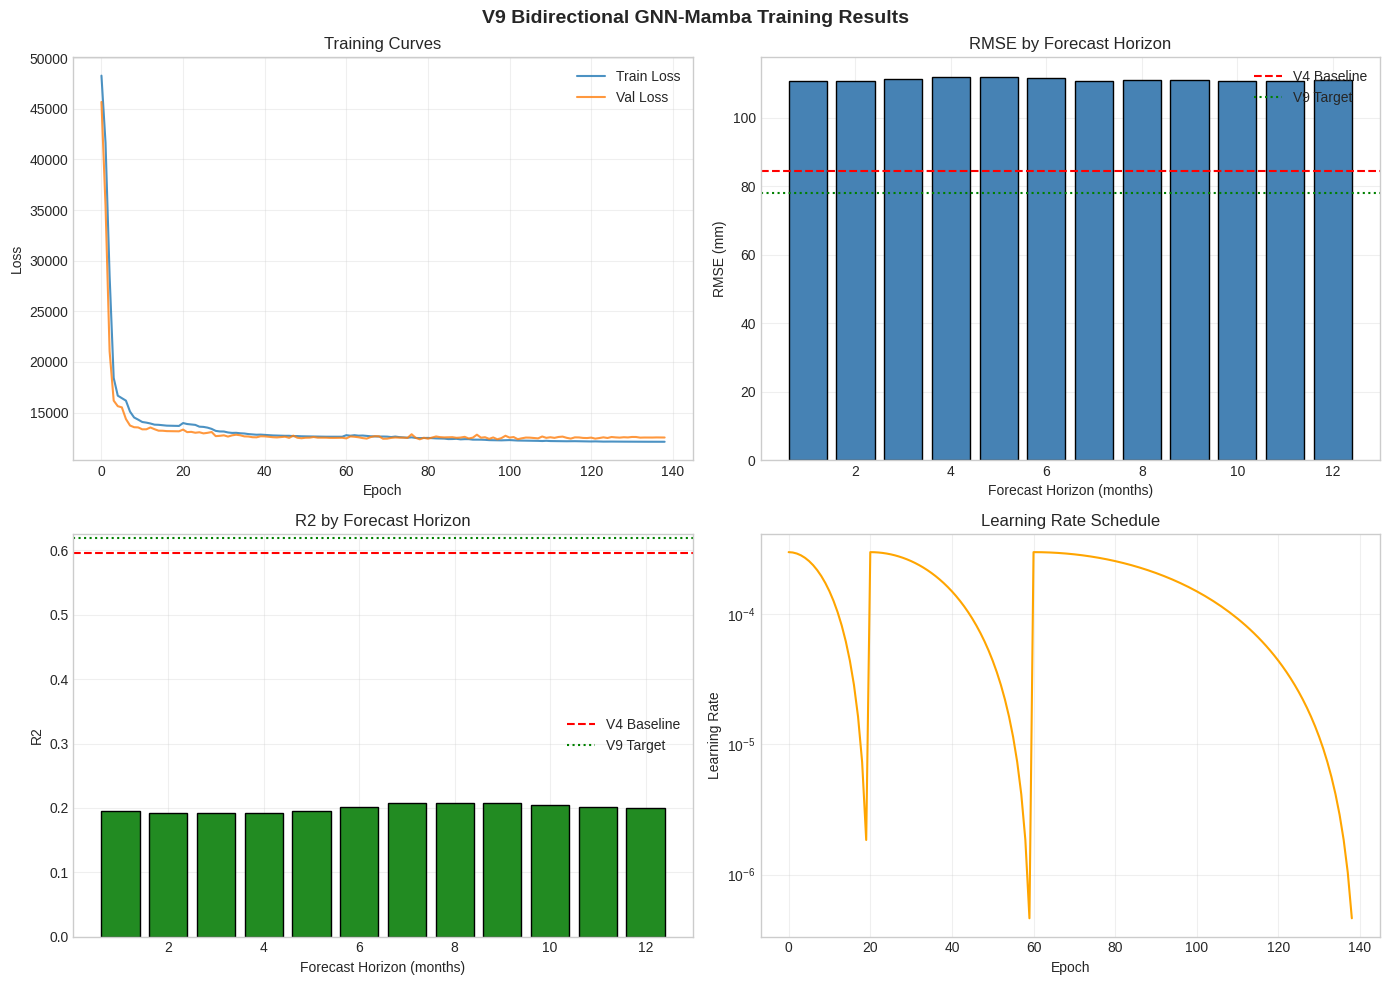

In [15]:
# ============================================================
# SECTION 8.1: VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training curves
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train Loss', alpha=0.8)
ax1.plot(history['val_loss'], label='Val Loss', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE by horizon
ax2 = axes[0, 1]
horizons = [m['H'] for m in eval_results['metrics']]
rmses = [m['RMSE'] for m in eval_results['metrics']]
ax2.bar(horizons, rmses, color='steelblue', edgecolor='black')
ax2.axhline(y=84.37, color='red', linestyle='--', label='V4 Baseline')
ax2.axhline(y=CONFIG.target_rmse, color='green', linestyle=':', label='V9 Target')
ax2.set_xlabel('Forecast Horizon (months)')
ax2.set_ylabel('RMSE (mm)')
ax2.set_title('RMSE by Forecast Horizon')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R2 by horizon
ax3 = axes[1, 0]
r2s = [m['R^2'] for m in eval_results['metrics']]
ax3.bar(horizons, r2s, color='forestgreen', edgecolor='black')
ax3.axhline(y=0.596, color='red', linestyle='--', label='V4 Baseline')
ax3.axhline(y=CONFIG.target_r2, color='green', linestyle=':', label='V9 Target')
ax3.set_xlabel('Forecast Horizon (months)')
ax3.set_ylabel('R2')
ax3.set_title('R2 by Forecast Horizon')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning rate schedule
ax4 = axes[1, 1]
ax4.plot(history['lr'], color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

plt.suptitle('V9 Bidirectional GNN-Mamba Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()

fig_path = FIG_OUT_DIR / 'v9_training_results.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

In [16]:
# ============================================================
# SECTION 8.2: SAVE RESULTS
# ============================================================

# Save metrics
metrics_df = pd.DataFrame(eval_results['metrics'])
metrics_df.to_csv(COMP_DIR / 'v9_metrics.csv', index=False)
print(f"Metrics saved to: {COMP_DIR / 'v9_metrics.csv'}")

# Save training history
if getattr(CONFIG, 'export_history', True):
    history_df = pd.DataFrame({
        'epoch': np.arange(1, len(history['train_loss']) + 1),
        'train_loss': history['train_loss'],
        'val_loss': history['val_loss'],
        'train_mse': history['train_mse'],
        'val_mse': history['val_mse'],
        'lr': history['lr']
    })
    history_df.to_csv(TRAIN_LOG_DIR / 'v9_training_log.csv', index=False)
    print(f"Training history saved to: {TRAIN_LOG_DIR / 'v9_training_log.csv'}")

# Save predictions and targets
if getattr(CONFIG, 'export_predictions', True):
    np.save(DATA_OUT_DIR / 'predictions.npy', eval_results['predictions'])
    np.save(DATA_OUT_DIR / 'targets.npy', eval_results['targets'])

    meta = {
        'n_samples': int(eval_results['predictions'].shape[0]),
        'n_nodes': int(eval_results['predictions'].shape[1]),
        'horizon': int(CONFIG.horizon),
        'n_lat': int(CONFIG.n_lat),
        'n_lon': int(CONFIG.n_lon)
    }
    with open(DATA_OUT_DIR / 'metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Predictions saved to: {DATA_OUT_DIR}")

# Save data report
if 'data_report' in globals():
    with open(OUTPUT_ROOT / 'v9_data_report.json', 'w') as f:
        json.dump(data_report, f, indent=2)
    print(f"Data report saved to: {OUTPUT_ROOT / 'v9_data_report.json'}")

# Save config
with open(OUTPUT_ROOT / 'v9_config.json', 'w') as f:
    json.dump(asdict(CONFIG), f, indent=2)
print(f"Config saved to: {OUTPUT_ROOT / 'v9_config.json'}")

print("\nAll results saved successfully!")

Metrics saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/comparisons/v9_metrics.csv
Training history saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/training_metrics/v9_training_log.csv
Predictions saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/data
Data report saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/v9_data_report.json
Config saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V9_GNN_BiMamba/v9_config.json

All results saved successfully!


In [17]:
# ============================================================
# SECTION 8.3: COLAB DISCONNECT
# ============================================================

if IN_COLAB:
    try:
        from google.colab import runtime
        runtime.unassign()
        print('Colab runtime disconnected.')
    except Exception as exc:
        print(f"Colab runtime disconnect failed: {exc}")
else:
    print('Not running in Colab; skip disconnect.')

Colab runtime disconnected.


## 9. Conclusions

### V9 Bidirectional GNN-Mamba Summary

**Key Innovations:**
1. **BidirectionalMamba** (RiverMamba NeurIPS 2025): Improved bidirectional temporal processing
2. **FrequencyTuning** (S4D-FT WRR 2025): Learnable frequency domain filtering for seasonal patterns
3. **GeographicEncoding** (WSSM arXiv 2025): Spatial position embeddings for geographic awareness

**Architecture:**
- Input: 60 months of precipitation data
- Output: 12-month ahead predictions
- Spatial: GNN with GAT layers + Geographic Encoding
- Temporal: BidirectionalMamba + FrequencyTuning
- Fusion: Cross-modal attention

**Expected Performance:**
- Target R2: > 0.62 (vs V4 baseline 0.596)
- Target RMSE: < 78 mm (vs V4 baseline 84.37 mm)